# <u>Test Exercice 6 - Time Series<u>

__<u>Jorge Pineño Pérez<u>__ / Module 6 - Time Series

This test exercise uses data that are available in the data file TestExer6. The question of interest is to model monthly inflation in the Euro area and to investigate whether inflation in the United States of America has predictive power for inflation in the Euro area. Monthly data on the consumer price index (CPI) for the Euro area and the USA are available from January 2000 until December 2011. The data for January 2000 until December 2010 are used for specification and estimation of models, and the data for 2011 are left out for forecast evaluation purposes.

In [1]:
# import packages
install.packages("readxl")
install.packages("dplyr")
install.packages("tidyr")
install.packages("zoo")
install.packages("ggplot2")
install.packages("dynlm")
library(readxl)
library(dplyr)
library(ggplot2)
library(zoo)
library(tidyr)
library(dynlm)

Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'readxl' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages


Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'dplyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages


Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages


Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'zoo' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages


Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages


Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'dynlm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpmuZVcQ\downloaded_packages



Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Adjuntando el paquete: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [10]:
# import the dataframe
infl <- read_excel('TestExer-6-CPI-round1.xlsx')
head(infl)

YYYY-MM,TREND,CPI_EUR,CPI_USA,LOGPEUR,LOGPUSA,DPEUR,DPUSA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2000M01,1,105.1,107.6,4.654912,4.678421,NA,NA
2000M02,2,105.4,108.3,4.657763,4.684905,2.85035822435642E-3,6.4845062792606703E-3
2000M03,3,105.8,109.1,4.661551,4.692265,3.78788331693691E-3,7.35973883208007E-3
2000M04,4,105.9,109.2,4.662495,4.693181,9.4473318316179401E-4,9.1617047177994205E-4
2000M05,5,106.0,109.3,4.663439,4.694096,9.4384150470627705E-4,9.1533187168835097E-4
2000M06,6,106.4,109.9,4.667206,4.699571,3.7664827954770799E-3,5.4744662270831404E-3


In [11]:
# change the name of the column "YYYY-MM" to "DATE", and change to a more convenient format
infl <- rename(infl, 'DATE' = 'YYYY-MM')
infl$DATE <- as.Date(paste0(sub("M", "-", infl$DATE), "-01"))

# change the type of the DPEUR and DPUSA for later use
infl$DPEUR <- as.numeric(infl$DPEUR)
infl$DPUSA <- as.numeric(infl$DPUSA)

head(infl)

Warning message:
"NAs introducidos por coerción"
Warning message:
"NAs introducidos por coerción"


DATE,TREND,CPI_EUR,CPI_USA,LOGPEUR,LOGPUSA,DPEUR,DPUSA
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000-01-01,1,105.1,107.6,4.654912,4.678421,NA,NA
2000-02-01,2,105.4,108.3,4.657763,4.684905,0.0028503582,0.0064845063
2000-03-01,3,105.8,109.1,4.661551,4.692265,0.0037878833,0.0073597388
2000-04-01,4,105.9,109.2,4.662495,4.693181,0.0009447332,0.0009161705
2000-05-01,5,106.0,109.3,4.663439,4.694096,0.0009438415,0.0009153319
2000-06-01,6,106.4,109.9,4.667206,4.699571,0.0037664828,0.0054744662


In [47]:
# convert the tibble to a zoo object (time-series) for later use
infl_ts <- zoo(cbind(
    TREND = infl$TREND,
    CPI_EUR = infl$CPI_EUR,
    CPI_USA = infl$CPI_USA,
    LOGPEUR = infl$LOGPEUR,
    LOGPUSA	= infl$LOGPUSA,
    DPEUR = infl$DPEUR,
    DPUSA = infl$DPUSA
), order.by=infl$DATE) # use 2000M01-2010M12 as estimation and test sample,
                       # and 2011 as hold-out forecast evaluation sample
head(infl_ts)

           TREND CPI_EUR CPI_USA  LOGPEUR  LOGPUSA        DPEUR        DPUSA
2000-01-01     1   105.1   107.6 4.654912 4.678421           NA           NA
2000-02-01     2   105.4   108.3 4.657763 4.684905 0.0028503582 0.0064845063
2000-03-01     3   105.8   109.1 4.661551 4.692265 0.0037878833 0.0073597388
2000-04-01     4   105.9   109.2 4.662495 4.693181 0.0009447332 0.0009161705
2000-05-01     5   106.0   109.3 4.663439 4.694096 0.0009438415 0.0009153319
2000-06-01     6   106.4   109.9 4.667206 4.699571 0.0037664828 0.0054744662

__(a)__ Make time series plots of the CPI of the Euro area and the USA, and also of their logarithm log(CPI) and of the two monthly inflation series $\text{DP} = \Delta \text{log(CPI)}$. What conclusions do you draw from these plots?

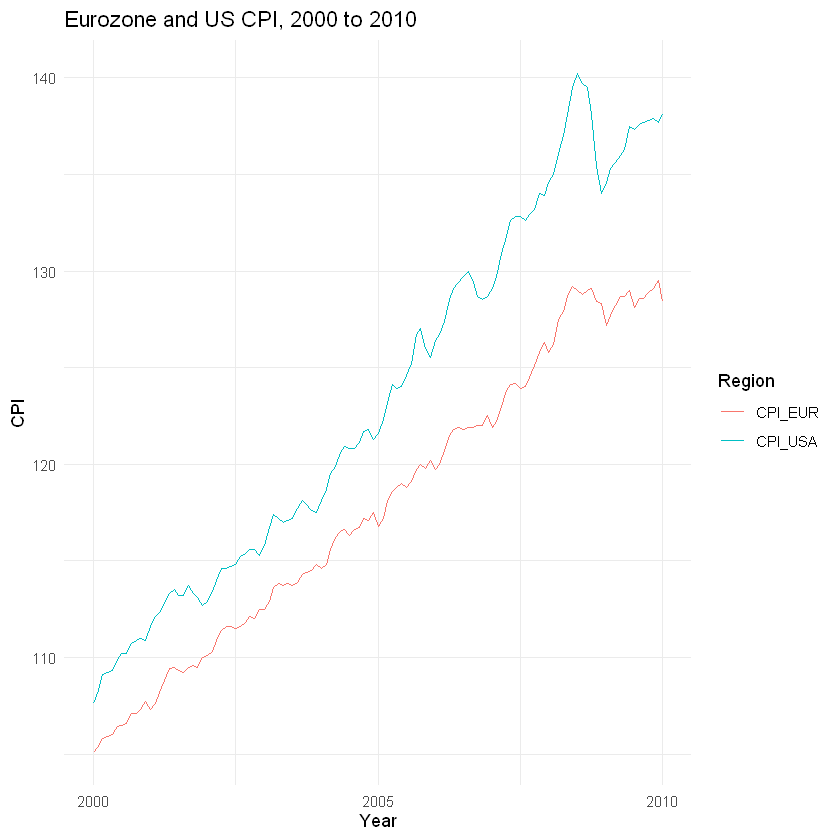

In [13]:
# plot the European CPI (CPI_EUR) and the US one (CPI_USA)
cpi_plot <- infl %>%
  filter(DATE>=as.Date('2000-01-01'), DATE<=as.Date('2010-01-01')) %>%
  pivot_longer(cols=c(CPI_EUR, CPI_USA), names_to='Region', values_to='CPI') %>%
  ggplot(aes(x=DATE, y=CPI, color=Region)) +
  geom_line() +
  labs(title='Eurozone and US CPI, 2000 to 2010', x='Year', y='CPI') +
  theme_minimal()
show(cpi_plot)

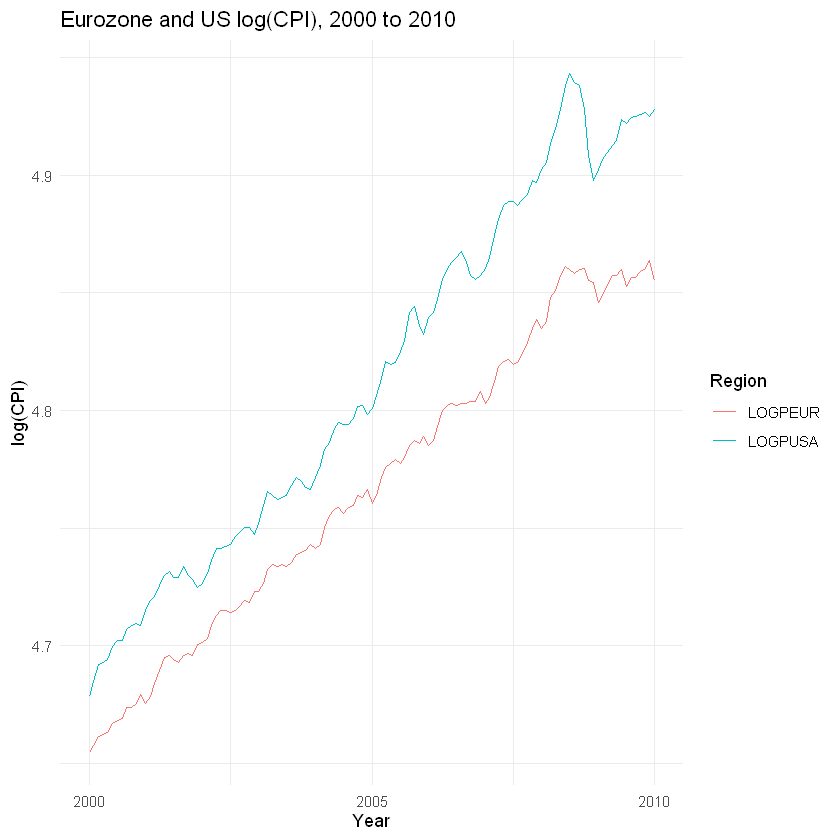

In [14]:
# plot the log of European CPI (LOGPEUR) and the US one (LOGPUSA)
log_cpi_plot <- infl %>%
  filter(DATE>=as.Date('2000-01-01'), DATE<=as.Date('2010-01-01')) %>%
  pivot_longer(cols=c(LOGPEUR, LOGPUSA), names_to='Region', values_to='LOGCPI') %>%
  ggplot(aes(x=DATE, y=LOGCPI, color=Region)) +
  geom_line() +
  labs(title='Eurozone and US log(CPI), 2000 to 2010', x='Year', y='log(CPI)') +
  theme_minimal()
show(log_cpi_plot)

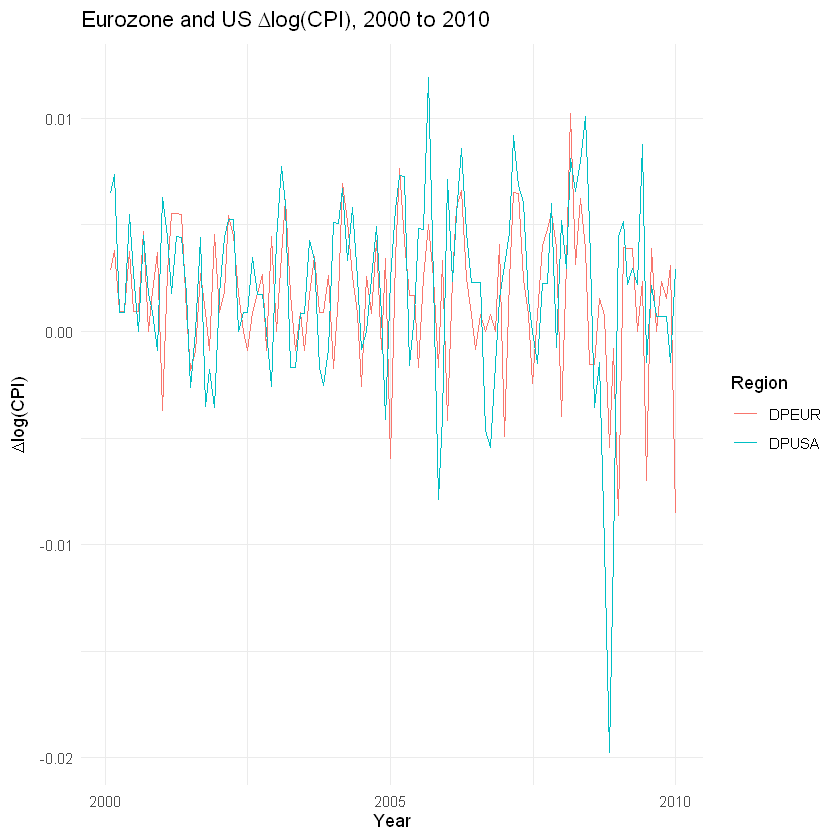

In [15]:
# plot the two montly inflation series "DP" (change in log(CPI))
log_cpi_plot <- infl %>%
  filter(DATE>=as.Date('2000-01-01'), DATE<=as.Date('2010-01-01')) %>%
  pivot_longer(cols=c(DPEUR, DPUSA), names_to='Region', values_to='DLOGCPI') %>% drop_na(DLOGCPI) %>%
  ggplot(aes(x=DATE, y=DLOGCPI, color=Region)) +
  geom_line() +
  labs(title=expression('Eurozone and US ' * Delta * 'log(CPI), 2000 to 2010'), x='Year', y=expression(Delta * 'log(CPI)')) +
  theme_minimal()
show(log_cpi_plot)

From these plots, we can draw 2 conclusions:

1) The movements in CPI and in $\text{log(CPI)}$ do appear graphically to happen in the US before than the Eurozone.
2) After computing the change in $\text{log(CPI)}$, the series appears to be stationary.

__(b)__ Perform the Augmented Dickey-Fuller (ADF) test for the two $\text{log(CPI)}$ series. In the ADF test equation, include a constant ($\alpha$), a deterministic trend term ($\beta t$), three lags of $\text{DP} = \Delta \text{log(CPI)}$ and, of course, the variable of interest $\text{log(CPI}_{t-1})$. Report the coefficient of $\text{log(CPI}_{t-1})$ and its standard error and t-value, and draw your conclusion.

In [24]:
# perform the ADF test for "LOGPEUR", including a constant, a deterministic
# trend term, three lags of "DPEUR", and a lag of "LOGPEUR", and check the coefficient of
# the lag of "LOGPEUR", and its standard error and t-value
adf_logpeur <- dynlm(DPEUR ~ as.numeric(index(infl_ts)) + L(DPEUR, 1) + L(DPEUR, 2) + L(DPEUR, 3) + L(LOGPEUR, 1),
                     data = infl_ts)
summary(adf_logpeur)


Time series regression with "zoo" data:
Start = 2000-05-01, End = 2011-12-01

Call:
dynlm(formula = DPEUR ~ as.numeric(index(infl_ts)) + L(DPEUR, 
    1) + L(DPEUR, 2) + L(DPEUR, 3) + L(LOGPEUR, 1), data = infl_ts)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0112038 -0.0015158  0.0002863  0.0020075  0.0096613 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                 5.531e-01  1.961e-01   2.820  0.00553 **
as.numeric(index(infl_ts))  7.748e-06  2.794e-06   2.773  0.00634 **
L(DPEUR, 1)                 1.445e-01  8.677e-02   1.665  0.09826 . 
L(DPEUR, 2)                -9.071e-02  8.524e-02  -1.064  0.28917   
L(DPEUR, 3)                -1.128e-01  8.574e-02  -1.315  0.19070   
L(LOGPEUR, 1)              -1.365e-01  4.865e-02  -2.805  0.00578 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003362 on 134 degrees of freedom
  (1 observation deleted due to mi

In [25]:
# perform the ADF test for "LOGPUSA", including a constant, a deterministic
# trend term, three lags of "DPUSA", and a lag of "LOGPUSA", and check the coefficient of
# the lag of "LOGPUSA", and its standard error and t-value
adf_logpusa <- dynlm(DPUSA ~ as.numeric(index(infl_ts)) + L(DPUSA, 1) + L(DPUSA, 2) + L(DPUSA, 3) + L(LOGPUSA, 1),
                     data = infl_ts)
summary(adf_logpusa)


Time series regression with "zoo" data:
Start = 2000-05-01, End = 2011-12-01

Call:
dynlm(formula = DPUSA ~ as.numeric(index(infl_ts)) + L(DPUSA, 
    1) + L(DPUSA, 2) + L(DPUSA, 3) + L(LOGPUSA, 1), data = infl_ts)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0131501 -0.0018609 -0.0001251  0.0019589  0.0088716 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 2.950e-01  1.069e-01   2.759  0.00661 ** 
as.numeric(index(infl_ts))  4.972e-06  1.881e-06   2.643  0.00920 ** 
L(DPUSA, 1)                 6.092e-01  8.405e-02   7.248 3.03e-11 ***
L(DPUSA, 2)                -1.509e-01  9.652e-02  -1.563  0.12031    
L(DPUSA, 3)                -6.425e-03  8.624e-02  -0.075  0.94072    
L(LOGPUSA, 1)              -7.432e-02  2.720e-02  -2.732  0.00714 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003506 on 134 degrees of freedom
  (1 observation deleted du

From our results, we conclude from the p-values of both lagged levels $(\text{log(CPI}_{t-1}))$, which are below $0.05$, that the two series are stationary, therefore rejecting the null of a unit root.

__(c)__ As the two series of $\log(\text{CPI})$ are not cointegrated (you need not check this), we continue by modelling the monthly inflation series $\text{DPEUR} = \Delta \log(\text{CPIEUR})$ for the Euro area. Determine the sample autocorrelations and the sample partial autocorrelations of this series to motivate the use of the following AR model:

$$\text{DPEUR}_t = \alpha + \beta_1 \text{DPEUR}_{t-6} + \beta_2 \text{DPEUR}_{t-12} + \varepsilon_t$$

Estimate the parameters of this model using the sample from January 2000 to December 2010.

In [22]:
# regress "DPEUR" on the variables above
dpeur_ar <- dynlm(DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12), data=infl_ts, end='2010-12-01')
summary(dpeur_ar)


Time series regression with "zoo" data:
Start = 2001-02-01, End = 2010-12-01

Call:
dynlm(formula = DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12), data = infl_ts, 
    end = "2010-12-01")

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0103343 -0.0017371 -0.0000475  0.0015321  0.0080904 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0003838  0.0002812   1.365   0.1749    
L(DPEUR, 6)  0.1887496  0.0772890   2.442   0.0161 *  
L(DPEUR, 12) 0.5979799  0.0835547   7.157 8.05e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.002569 on 116 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4232,	Adjusted R-squared:  0.4132 
F-statistic: 42.55 on 2 and 116 DF,  p-value: 1.381e-14


After estimating the parameters, the model is:

$$ \widehat{\text{DPEUR}_t} = 0.00 + 0.19 \text{DPEUR}_{t-6} + 0.61 \text{DPEUR}_{t-12} $$

__(d)__ Extend the AR model of part (c) by adding lagged values of monthly inflation in the USA at lags 1, 6,
and 12. Check that the coefficient at lag 6 is not significant, and estimate the ADL model

$$ \widehat{\text{DPEUR}_t} = \alpha + \beta_1 \text{DPEUR}_{t-6} + \beta_2 \text{DPEUR}_{t-12} + \gamma_1 \text{DPUSA}_{t-1} + \gamma_2 \text{DPUSA}_{t-12} + \varepsilon_t $$

Estimate the parameters of this model using the sample from January 2000 to December 2010.

In [26]:
# regress "DPEUR" on the variables above
dpeur_adl <- dynlm(DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12) + L(DPUSA, 1) + L(DPUSA, 6) + L(DPUSA, 12),
                   data=infl_ts, end='2010-12-01')
summary(dpeur_adl)


Time series regression with "zoo" data:
Start = 2001-02-01, End = 2010-12-01

Call:
dynlm(formula = DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12) + L(DPUSA, 
    1) + L(DPUSA, 6) + L(DPUSA, 12), data = infl_ts, end = "2010-12-01")

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0065866 -0.0016535 -0.0000117  0.0012633  0.0082683 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.0004407  0.0002853   1.545    0.125    
L(DPEUR, 6)   0.2029831  0.0785535   2.584    0.011 *  
L(DPEUR, 12)  0.6367563  0.0874784   7.279 4.78e-11 ***
L(DPUSA, 1)   0.2264303  0.0511299   4.429 2.20e-05 ***
L(DPUSA, 6)  -0.0560495  0.0547668  -1.023    0.308    
L(DPUSA, 12) -0.2300590  0.0541714  -4.247 4.47e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.002272 on 113 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5602,	Adjusted R-squared:  0.5408 
F-statistic: 28.7

In [27]:
# eliminate lag 6, as it is not significant
dpeur_adl <- dynlm(DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12) + L(DPUSA, 1) + L(DPUSA, 12),
                   data=infl_ts, end='2010-12-01')
summary(dpeur_adl)


Time series regression with "zoo" data:
Start = 2001-02-01, End = 2010-12-01

Call:
dynlm(formula = DPEUR ~ L(DPEUR, 6) + L(DPEUR, 12) + L(DPUSA, 
    1) + L(DPUSA, 12), data = infl_ts, end = "2010-12-01")

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0067809 -0.0016353  0.0000532  0.0013660  0.0082449 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.0003391  0.0002676   1.267   0.2076    
L(DPEUR, 6)   0.1687277  0.0710803   2.374   0.0193 *  
L(DPEUR, 12)  0.6551636  0.0856272   7.651 6.93e-12 ***
L(DPUSA, 1)   0.2326463  0.0507784   4.582 1.19e-05 ***
L(DPUSA, 12) -0.2265061  0.0540712  -4.189 5.55e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.002273 on 114 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5561,	Adjusted R-squared:  0.5406 
F-statistic: 35.71 on 4 and 114 DF,  p-value: < 2.2e-16


After estimating the parameters, the model is:

$$ \widehat{\text{DPEUR}_t} = 0.00 + 0.17 \text{DPEUR}_{t-6} + 0.66 \text{DPEUR}_{t-12} + 0.23 \text{DPUSA}_{t-1} - 0.23 \text{DPUSA}_{t-12} $$

__(e)__ Use the models of parts (c) and (d) to make two series of 12 monthly inflation forecasts for 2011. At each month, you should use the data that are then available, for example, to forecast inflation for September 2011 you can use the data up to and including August 2011. However, do not re-estimate the model and use the coefficients as obtained in parts (c) and (d). For each of the two forecast series, compute the values of the root mean squared error (RMSE), mean absolute error (MAE), and the sum of the forecast errors (SUM). Finally, give your interpretation of the outcomes.

In [48]:
# make 12 forecasts for each month of 2011 from the AR (c) model
infl_ts <- transform(infl_ts,
                     DPEUR_lag6 = stats::lag(DPEUR, -6), # create a DPEUR lag 6 column in the zoo object
                     DPEUR_lag12 = stats::lag(DPEUR, -12)) # create a DPEUR lag 12 column in the zoo object

dpeur_ar_fc <- coef(dpeur_ar)[1] + coef(dpeur_ar)[2] * infl_ts$DPEUR_lag6 + coef(dpeur_ar)[3] * infl_ts$DPEUR_lag12
window(dpeur_ar_fc, start = as.Date('2011-01-01'), end = as.Date('2011-12-31'))

   2011-01-01    2011-02-01    2011-03-01    2011-04-01    2011-05-01 
-0.0054396535  0.0025329985  0.0074256837  0.0037085512  0.0009843440 
   2011-06-01    2011-07-01    2011-08-01    2011-09-01    2011-10-01 
 0.0015285649 -0.0031931243  0.0020170638  0.0047708356  0.0033328943 
   2011-11-01    2011-12-01 
 0.0008386676  0.0040106362 

In [49]:
# make 12 forecasts for each month of 2011 from the ADL (d) model
infl_ts <- transform(infl_ts,
                     DPUSA_lag1 = stats::lag(DPUSA, -1), # create a DPUSA lag 1 column in the zoo object
                     DPUSA_lag12 = stats::lag(DPUSA, -12)) # create a DPUSA lag 12 column in the zoo object

dpeur_adl_fc <- coef(dpeur_adl)[1] + coef(dpeur_adl)[2] * infl_ts$DPEUR_lag6 + coef(dpeur_adl)[3] * infl_ts$DPEUR_lag12 + coef(dpeur_adl)[4] * infl_ts$DPUSA_lag1 + coef(dpeur_adl)[5] * infl_ts$DPUSA_lag12
window(dpeur_adl_fc, start = as.Date('2011-01-01'), end = as.Date('2011-12-31'))

   2011-01-01    2011-02-01    2011-03-01    2011-04-01    2011-05-01 
-0.0062192178  0.0036343690  0.0081137708  0.0058365577  0.0022699711 
   2011-06-01    2011-07-01    2011-08-01    2011-09-01    2011-10-01 
 0.0026582395 -0.0036430906  0.0018199295  0.0051123340  0.0036634088 
   2011-11-01    2011-12-01 
 0.0001922337  0.0036658403 

In [54]:
# compute the RMSE, MAE and SUM of the two forecasts done 
target_dates <- seq(as.Date('2011-01-01'), as.Date('2011-12-01'), by='month')

actual <- infl_ts$DPEUR[index(infl_ts) %in% target_dates]
forecast_ar <- dpeur_ar_fc[index(dpeur_ar_fc) %in% target_dates]
forecast_adl <- dpeur_adl_fc[index(dpeur_adl_fc) %in% target_dates]

errors_ar <- actual - forecast_ar
errors_adl <- actual - forecast_adl

rmse_ar <- sqrt(mean(errors_ar^2))
rmse_adl <- sqrt(mean(errors_adl^2))

mae_ar <- mean(abs(errors_ar))
mae_adl <- mean(abs(errors_adl))

sum_errors_ar <- sum(errors_ar)
sum_errors_adl <- sum(errors_adl)

# create a dataframe with the results
results <- data.frame(Model = c('AR', 'ADL'),
                      RMSE = c(rmse_ar, rmse_adl),
                      MAE = c(mae_ar, mae_adl),
                      Sum_Errors = c(sum_errors_ar, sum_errors_adl))
results[ , -1] <- round(results[ , -1], 6)
results

Model,RMSE,MAE,Sum_Errors
<chr>,<dbl>,<dbl>,<dbl>
AR,0.002324,0.001692,0.005065
ADL,0.002111,0.001404,0.000478


As we can see, the ADL model outperforms the AR model, having both a lower RMSE (0.002111 < 0.002324) and a lower MAE (0.001404 < 0.001692). This indicates that the ADL model produced forecasts that, on average, deviated less from the actual inflation values.

The ADL model’s sum of errors is much closer to zero (0.000478 < 0.005065), suggesting that its forecasts were not only more accurate in size but also less biased on average, i.e. they did not consistently under or overestimate inflation.